In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

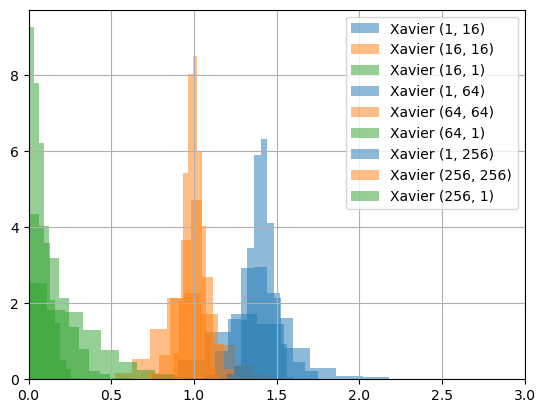

In [7]:
n = 1000
def xav_init(n, in_dim, out_dim):
    scale = (2 / (in_dim + out_dim)) ** 0.5
    W = scale * torch.randn((n, in_dim, out_dim))
    return W


for dim in [16, 64, 256]:
    for color, in_dim, out_dim in [
        ("tab:blue", 1,dim), ("tab:orange", dim, dim), ("tab:green",dim, 1)
    ]:
        x = torch.randn((n, in_dim))
        x = x/(x.norm(dim=-1, keepdim=True) + 1e-6)

        W = xav_init(n, in_dim, out_dim)
        y = torch.einsum('nij,ni->nj', W, x)
        norms = y.norm(dim=-1)
        plt.hist(norms, density=True, label=f'Xavier {in_dim, out_dim}', alpha=0.5, color=color)
plt.xlim(0, 3)
plt.legend()
plt.grid()
plt.show()

In [8]:
class MonoLinear(nn.Module):
    def __init__(self, in_dim, out_dim, weight_activation='identity'):
        super().__init__()
        self.w_act, self.w_act_inv = {
            'identity': (lambda x: x, lambda x: x),
            'abs': (torch.abs, torch.abs),
            "square": (torch.square, torch.sqrt),
        }[weight_activation]
        self.W = nn.Parameter(self.mono_init_w(in_dim, out_dim, self.w_act_inv))
        self.b = nn.Parameter(torch.zeros(out_dim))
        
    @staticmethod
    def mono_init_w(in_dim, out_dim, w_act_inv):
        xav_scale = (2/ (in_dim + out_dim)) ** 0.5
        W = xav_scale * torch.randn((in_dim, out_dim))
        return W
        diag_scale = (min((in_dim, out_dim))/(in_dim+out_dim)) ** 0.5
        W += diag_scale*torch.eye(max(in_dim, out_dim))[:in_dim, :out_dim]
        return w_act_inv(torch.relu(W))

    def forward(self, x):
        W = self.w_act(self.W)
        x = x @ W + self.b
        return x

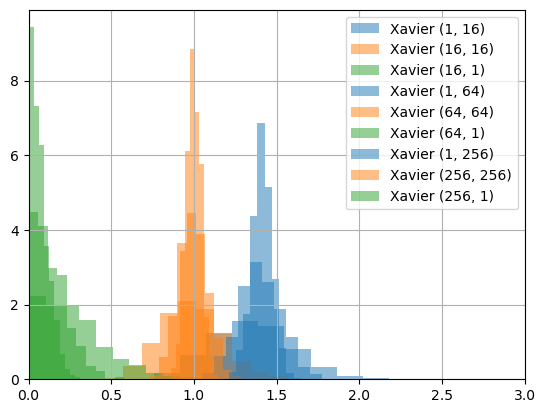

In [9]:
def mono_init(n, in_dim, out_dim):
    return torch.stack(
        [MonoLinear.mono_init_w(in_dim, out_dim, lambda x:x) 
        for _ in range(n)]
    )

for dim in [16, 64, 256]:
    for color, in_dim, out_dim in [
        ("tab:blue", 1,dim), ("tab:orange", dim, dim), ("tab:green",dim, 1)
    ]:
        x = torch.randn((n, in_dim))
        x = x/(x.norm(dim=-1, keepdim=True) + 1e-6)
        
        W = mono_init(n, in_dim, out_dim)
        y = torch.einsum('nij,ni->nj', W, x)
        norms = y.norm(dim=-1)
        plt.hist(norms, density=True, label=f'Xavier {in_dim, out_dim}', alpha=0.5, color=color)
plt.xlim(0, 3)
plt.legend()
plt.grid()
plt.show()

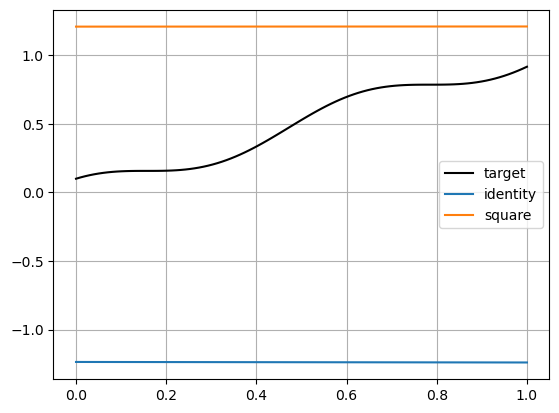

In [10]:
dim = 256
x = torch.linspace(0, 1, 100).unsqueeze(-1)
target = torch.cos(10*x)/10+x

models = {
    weight_activation: nn.Sequential(
        MonoLinear(1, dim, weight_activation), 
        nn.Sigmoid(), 
        MonoLinear(dim, dim, weight_activation),
        nn.Sigmoid(), 
        MonoLinear(dim, 1, weight_activation)
    )
    for weight_activation in [
        'identity', 'square'
    ]
}

plt.plot(x, target, "k", label='target')
for weight_activation, model in models.items():
    plt.plot(x, model(x).detach(), label=weight_activation)
plt.legend()
plt.grid()
plt.show()

In [11]:
from tqdm.auto import tqdm
losses = {model: [] for model in models.keys()}
for name, model in models.items():
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in (pbar:=tqdm(range(10000))):
        loss = ((model(x)- target)**2).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.set_postfix({'rmse': loss.item()**0.5})
        losses[name].append(loss.item())


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

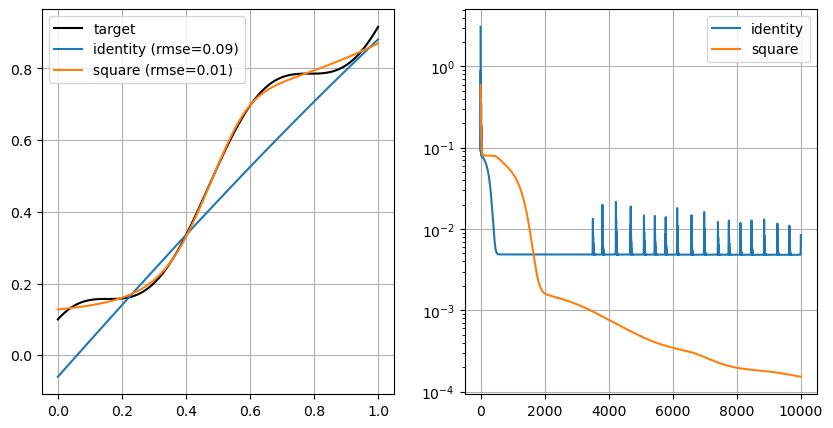

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x, target, "k", label='target')
for name, model in models.items():
    y = model(x).detach()
    plt.plot(x, y, label=f'{name} (rmse={losses[name][-1]**0.5:.2f})')
plt.grid()
plt.legend()
plt.subplot(122)
for name, loss in losses.items():
    plt.semilogy(loss, label=name)
plt.legend()
plt.grid()
plt.show()